## Imports

In [7]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from gwpy.timeseries import TimeSeries

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

### Helper functions

In [4]:
def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak
    

### Grab waveform from frames files

In [12]:
def GetFramesData(p, det = 'H1'):
    
    sH = TimeSeries.read(source = p + '/Frames_dCS/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = np.array(sH.times)
    tH = SubtractPeakTime(tH, sH)
    return tH, sH

### Get BW reconstructed waveforms

### Get Surrogate waveforms

#### Import surrogate

In [23]:
import gwsurrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


#### Evaluate Surrogate

In [ ]:


def 

time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(params_dict, surrogate_projection=True)


## Surrogate evaluation
def EvaluateSurrogate(params_dict, surrogate_projection=True):
    """ Evaluate the surrogate waveform 
        If surrogate_projection is true, then use the native surrogate inclination calculation routine
        Otherwise combine ourselves using SWSH"""
    
    if (surrogate_projection):
        ## Use the native surrogate inclination computation
   
        """ Surrogate documentation: If inclination/phi_ref are specified, the complex strain (h =
                 hplus -i hcross) evaluated at (inclination, pi/2 - phi_ref) on
                 the sky of the reference frame is returned.
         
            In order to agree with NR convetions, need phi_ref = pi/2 - phi"""

        data = sur(params_dict['q'], params_dict['a_1'], params_dict['a_2'], \
                   dt = params_dict['dt'], units = 'mks', M = params_dict['mass'], \
                   dist_mpc = params_dict['dist_mpc'], f_low = params_dict['f_low'], \
                   inclination = params_dict['theta'], ellMax = 4, phi_ref = pi/2 - params_dict['phi']) 

        time = data[0]
        h_plus = np.real(data[1])
        h_cross = -1 * np.imag(data[1])
        
        time = time - time[0]
        #ramp = np.array([Ramp(t, 0.27, 0.3) for t in time])
        ramp = np.array([Ramp(t, 0.22, 0.25) for t in time])
    
        h_plus = h_plus * ramp
        h_cross = h_cross * ramp
    
        ## Now subtract off the peak time (this makes the spine interpolation easier)
        amp = np.sqrt(h_plus**2 + h_cross**2)
        time = time - time[np.argmax(amp)]
    
        return time, h_plus, h_cross, np.sqrt(h_plus**2 + h_cross**2)
    
    

In [21]:
def GetBWDir(p):
    return p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'

def GetMedianData(p, det = 'H1'):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    ## Grab Livingston data
    f = GetBWDir(p) + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1 #, d2, d3, d4, d5

def GetInjectedData(p, det = 'H1'):

    f = GetBWDir(p) + 'post/whitened_data_' + det + '.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data

### Plot reconstructions

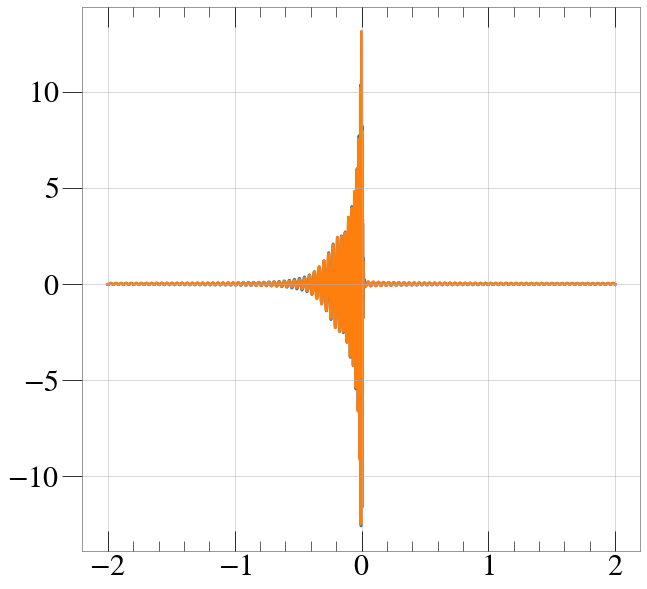

In [22]:
p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/dCS_0p0_75'

t_inj, data_inj = GetInjectedData(p)
t_med, data_med = GetMedianData(p)
t_frame, data_frame = GetFramesData(p)

plt.figure(figsize=(10,10))
plt.plot(t_inj, data_inj)
plt.plot(t_med, data_med)
#plt.plot(t_frame, data_frame)
plt.show()

## Compute overlaps

/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
[0.001494397364503408]
0.0 m
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p1/dCS_0

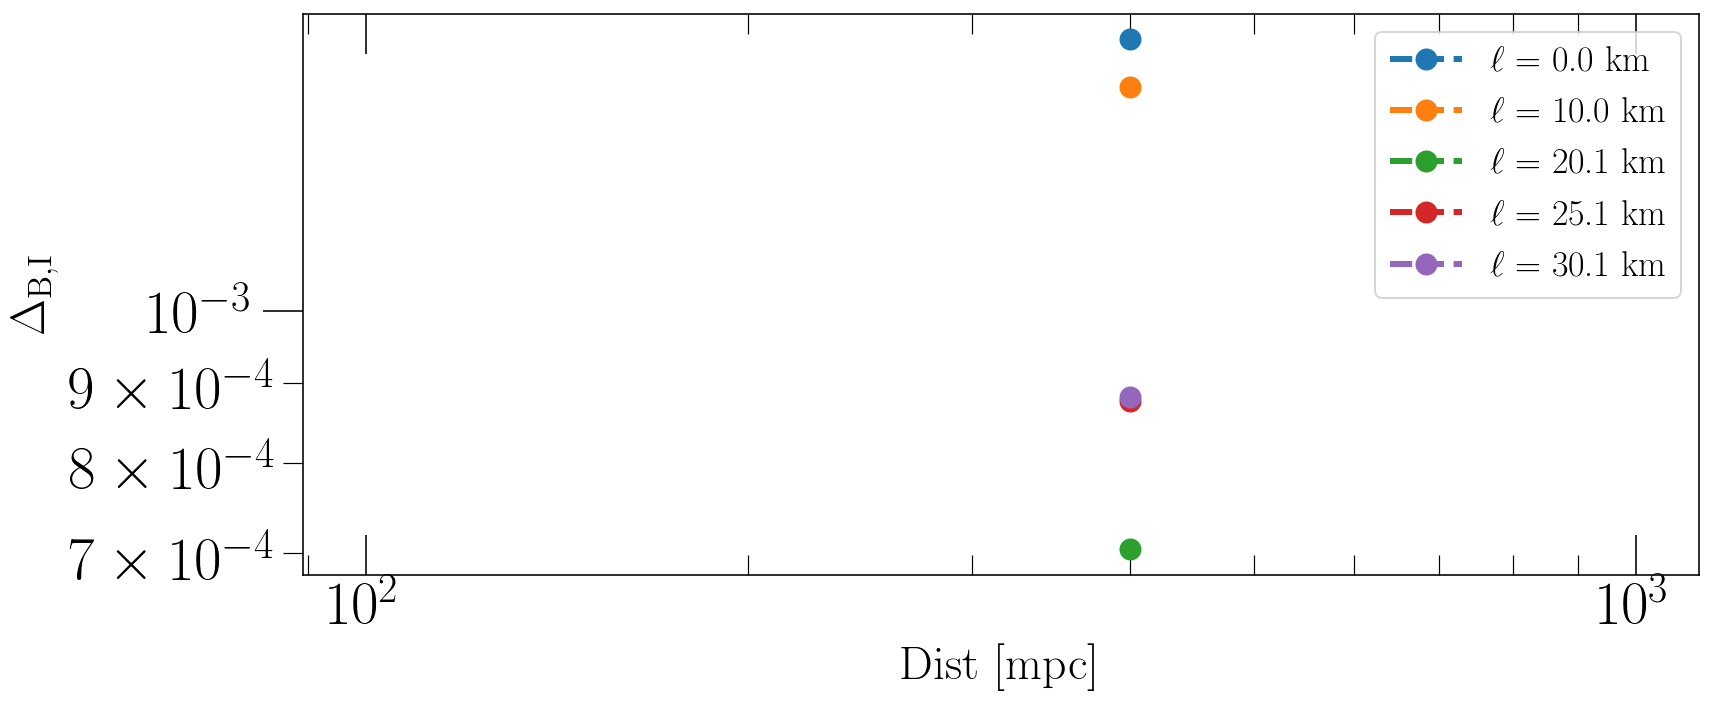

In [61]:

def InnerProduct(freq, hA, hB, PSD):

    """ Compute the inner product using the conventions of 
    https://arxiv.org/abs/2003.09456 Eq. 8"""
    
    ## Spacing in frequency
    df = freq[1] - freq[0]
    
    ## Terms inside the integral
    product = hA * np.conj(hB) / PSD 
    
    ## Compute the integral 
    total = 4.0 * np.real(np.sum(product)) * df
    return total
    
def Overlap(ell, dist_mpc, mass):
    
    """ Compute the overlap between the injected 
        waveform and the BW waveform for a given dCS
        coupling constant and SNR. Uses the conventions 
        of https://arxiv.org/abs/2003.09456 """
    
    ## compute the network inner products
    
    total_bw_inj = 0.0
    total_bw_bw = 0.0
    total_inj_inj = 0.0
    
    ## Compute the inner products summer over detectors.
    ## See Eq. 7 of https://arxiv.org/abs/2003.09456
    for detector in ["L1", "H1"]:
        
        ## Grab the psd, bw, and injected data for this detector
        freq, psd = GetPSD(ell, dist_mpc, mass, detector)
        freq, bw, d2, d3, d4, d5 = GetBWFrequencyDomainWaveform(ell, dist_mpc, mass, detector)
        freq, inj = GetInjectedFrequencyDomainWaveform(ell, dist_mpc, mass, detector)
        
        total_bw_inj = total_bw_inj + InnerProduct(freq, bw, inj, psd)
        total_bw_bw = total_bw_bw + InnerProduct(freq, bw, bw, psd)
        total_inj_inj = total_inj_inj + InnerProduct(freq, inj, inj, psd)
        
    #print(total_bw_inj, total_bw_bw, total_inj_inj)
    
    ## Eq. 6 in https://arxiv.org/abs/2003.09456
    overlap = total_bw_inj / np.sqrt(total_bw_bw  * total_inj_inj)
    return overlap
    

plt.figure(figsize=(12, 5))

ells = [0.0, 0.1, 0.2, 0.25, 0.3]
#colors = ['blue', '#148c8a', '#45ba7e']
dist_arr = [400]
mass = 68

for ell in ells:
    
    ## compute the overlap for the median waveform
    deltas = [1.0 - Overlap(ell, dist, mass) for dist in dist_arr]
    print(deltas)
    plt.plot(dist_arr, deltas, '--o', label=r'$\ell$ = ' + EllinKm(ell, mass), markersize=10)
    
## Add in 1/SNR^2 curve 
#snrs = np.linspace(SNRs[0], SNRs[-1], 100)
#snr_curve = snrs**-2.0
#plt.plot(snrs, snr_curve*100, color='black')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$\Delta_\mathrm{B,I}$')
plt.xlabel('Dist [mpc]')
plt.tight_layout()
plt.savefig('Deltas.pdf')

plt.show()
    